In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# URL du dataset WeatherBench 2 sur Google Cloud
url = "gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr"

# Ouverture lazy (ne charge rien encore en mémoire)
ds = xr.open_zarr(url, consolidated=True)

In [ ]:
date = "2012-08-25T15:00:00"
tp6 = ds["total_precipitation_6hr"].sel(time=date, method="nearest", tolerance="3H")

c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


In [ ]:
# Recentrer longitudes en [-180, 180] et découper Europe
tp6 = tp6.assign_coords(longitude=(((tp6.longitude + 180) % 360) - 180)).sortby("longitude")
tp6_eu_mm = tp6.sel(longitude=slice(-12.5, 42.5), latitude=slice(75, 35)) * 1000.0  # mm/6h

In [ ]:
# Carte avec frontières
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=proj)
ax.set_extent([-25, 45, 35, 70], crs=proj)

tp6_eu_mm.plot(
    ax=ax,
    transform=proj,                # important : vos données sont en lat/lon
    cmap="Blues",
    cbar_kwargs={"label": "Total precipitation (mm / 6h)"}
)

# Contexte géographique
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)
ax.add_feature(cfeature.LAKES.with_scale("50m"), edgecolor="k", facecolor="none", linewidth=0.5)
ax.add_feature(cfeature.RIVERS.with_scale("50m"), linewidth=0.4)

# Graticule propre
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.4)
gl.right_labels = False; gl.top_labels = False

plt.title(f"ERA5 (WB2) — Total precipitation (6h) — {str(tp6.time.values)[:19]} UTC")
plt.show()

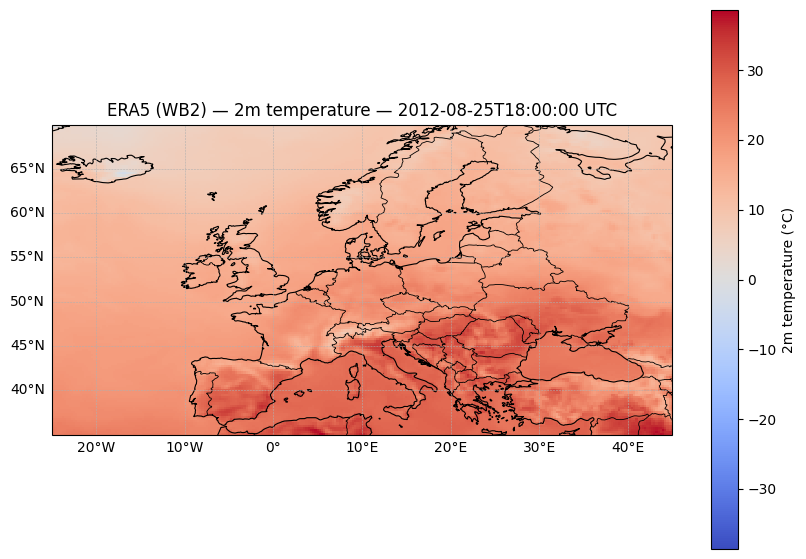

In [9]:
# 2) Extraire T2M à cette date (K) et convertir en °C
t2m = ds["2m_temperature"].sel(time=date, method="nearest", tolerance="3H") - 273.15  # °C

# 3) Recentrer lon en [-180,180] et trier
t2m = t2m.assign_coords(longitude=(((t2m.longitude + 180) % 360) - 180)).sortby("longitude")

# 4) Europe (lon -25..45, lat 35..70 ; lat décroît dans ERA5)
t2m_eu = t2m.sel(longitude=slice(-25, 45), latitude=slice(70, 35))

# 5) Carte
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=proj)
ax.set_extent([-25, 45, 35, 70], crs=proj)

im = t2m_eu.plot(
    ax=ax, transform=proj, cmap="coolwarm",
    cbar_kwargs={"label": "2m temperature (°C)"}
)

ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.4)
gl.right_labels = False; gl.top_labels = False

plt.title(f"ERA5 (WB2) — 2m temperature — {str(t2m.time.values)[:19]} UTC")
plt.show()